<a href="https://colab.research.google.com/github/michalejan/EEG-Neural-Representation-Prediciton-Model_BA/blob/main/EEG_Preprocessing_allsubs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# STEP 1. DOWNLOADING THE WHOLE BATCH OF EEG SIGNALS FOR ALL SUBJECTS

In [ ]:
!pip install openneuro-py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.1/41.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.6/85.6 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 13.0 MB/s eta 0:00:00


In [ ]:
import os
import openneuro

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
target_dir = "/content/drive/MyDrive/EEG_data/full_subject_list"


In [ ]:
if not os.path.exists(target_dir):
    os.makedirs(target_dir)

In [ ]:
openneuro.download(dataset='ds004771', target_dir=target_dir)


👋 Hello! This is openneuro-py 2025.2.0. Great to see you! 🤗

   👉 Please report problems 🤯 and bugs 🪲 at
      https://github.com/hoechenberger/openneuro-py/issues

🌍 Preparing to download ds004771 …


📁 Traversing directories for ds004771 : 0 entities [00:00, ? entities/s]

📥 Retrieving up to 331 files (5 concurrent downloads). 
✅ Finished downloading ds004771.
 
🧠 Please enjoy your brains.
 


# STEP 2. LOADING THE EEG DATA INTO PY

In [ ]:
!pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 37.6 MB/s eta 0:00:00


In [ ]:
import mne
import pandas as pd
import numpy as np
import os
import glob

In [ ]:
base_path = '/content/drive/MyDrive/EEG_data/full_subject_list'
save_path = '/content/drive/MyDrive/EEG_data/P600_Results/all_subs'

In [ ]:
if not os.path.exists(save_path):
    os.makedirs(save_path)

In [ ]:
# Analysis Parameters
roi_channels = ['Pz', 'Cz', 'CP1', 'CP2', 'P3', 'P4']
t_min, t_max = 0.5, 0.8  # 500-800ms
l_freq, h_freq = 0.1, 30.0

# STEP 3. LOADING PARTICIPANT LIST


In [ ]:
tsv_file = os.path.join(base_path, 'participants.tsv')

In [ ]:
if os.path.exists(tsv_file):
    meta_df = pd.read_csv(tsv_file, sep='\t')

    # FILTERING LOGIC: Keep only 'good' subjects
    good_subjects = meta_df[meta_df['data_usability'] == 'good']
    subject_list = good_subjects['participant_id'].tolist()

    print(f"📋 Metadata loaded.")
    print(f"   - Total in file: {len(meta_df)}")
    print(f"   - Excluded (Bad): {len(meta_df) - len(subject_list)}")
    print(f"   - Included (Good): {len(subject_list)}")

else:
    # Fallback if file is missing (process everything)
    print("⚠️ participants.tsv not found. Processing ALL folders.")
    subject_list = [d for d in os.listdir(base_path) if d.startswith('sub-')]

subject_list.sort()
print(f"✅ Ready to process {len(subject_list)} subjects.")

📋 Metadata loaded.
   - Total in file: 61
   - Excluded (Bad): 16
   - Included (Good): 45
✅ Ready to process 45 subjects.


# STEP 4. PREPROCESSING LOOP

Analysis Parameters
<br>roi_channels = ['Pz', 'Cz', 'CP1', 'CP2', 'P3', 'P4'] <br>t_min, t_max = 0.5, 0.8  # 500-800ms  <br>l_freq, h_freq = 0.1, 30.0 <br>

Below can be seen a batch-processing pipeline that iterates through our validated subject list. For each participant, it effectively 'cleans' the signal (filtering & baselining), translates the raw event codes into 'Control/Violation' conditions, and extracts the mean amplitude specifically from the P600 time window (500-800ms) over our parietal ROI. The system includes error handling to skip corrupted files without stopping the batch, and it outputs a master dataset ready for T-tests.

## CHECK UP whether all participants are loaded

In [ ]:
# 1. Define Path (Check capitalization carefully!)
base_path = '/content/drive/MyDrive/EEG_data/full_subject_list'
tsv_path = os.path.join(base_path, 'participants.tsv')

print(f"📂 Checking Path: {base_path}")

📂 Checking Path: /content/drive/MyDrive/EEG_data/full_subject_list


In [ ]:
# 2. Check if Metadata exists
if os.path.exists(tsv_path):
    print("✅ participants.tsv FOUND.")
    df = pd.read_csv(tsv_path, sep='\t')

    # Check for the column name (handling capital letters/spaces)
    col_name = [c for c in df.columns if 'usability' in c]
    if col_name:
        col = col_name[0]
        good_subjects = df[df[col] == 'good']['participant_id'].tolist()
        print(f"   - The file lists {len(good_subjects)} 'GOOD' subjects (Target).")
        print(f"   - The file lists {len(df) - len(good_subjects)} 'BAD' subjects.")
    else:
        print("   ❌ Column 'data_usability' not found in TSV.")
else:
    print("❌ CRITICAL: participants.tsv NOT found.")
    print("   (This is why the code processed everyone!)")
    # Check if it is inside a subfolder (common OpenNeuro issue)
    alt_path = os.path.join(base_path, 'ds004771', 'participants.tsv')
    if os.path.exists(alt_path):
        print(f"   💡 Found it in subfolder: {alt_path}")
        print("   -> We need to adjust your base_path.")

✅ participants.tsv FOUND.
   - The file lists 45 'GOOD' subjects (Target).
   - The file lists 16 'BAD' subjects.


In [ ]:
# 3. Check Actual Folders
if os.path.exists(base_path):
    folders = [f for f in os.listdir(base_path) if f.startswith('sub-') and os.path.isdir(os.path.join(base_path, f))]
    folders.sort()
    print(f"\n📁 Actual Folders on Drive: {len(folders)}")

    # Compare
    if 'good_subjects' in locals():
        missing = [s for s in good_subjects if s not in folders]
        if missing:
            print(f"⚠️ MISSING DATA: You are missing these {len(missing)} 'GOOD' subjects:")
            print(f"   {missing}")
        else:
            print("✅ All 45 Good subjects are present.")


📁 Actual Folders on Drive: 61
✅ All 45 Good subjects are present.


## PROCESSING ALL AT ONCE (ALL SUBS)

In [ ]:
all_subjects_stats = []
for sub_id in subject_list:
    print(f"\nProcessing: {sub_id} ...")

    try:
        # 1. Locate File
        sub_folder = os.path.join(base_path, sub_id)
        # Look for .set file recursively
        set_files = glob.glob(os.path.join(sub_folder, '**', '*.set'), recursive=True)

        if not set_files:
            print(f"   ❌ Skipped: No .set file found.")
            continue

        fname = set_files[0]

        # 2. Load & Preprocess
        epochs = mne.read_epochs_eeglab(fname, verbose=False)
        epochs.filter(l_freq, h_freq, verbose=False)
        epochs.apply_baseline((-0.1, 0), verbose=False)

        # 3. Resolve Labels
        id_to_text = {v: k for k, v in epochs.event_id.items()}

        def solve_label(event_id):
            text_label = id_to_text.get(event_id, "")
            if '(110)' in text_label or '(115)' in text_label: return 'Control'
            if '(220)' in text_label or '(225)' in text_label: return 'Violation'
            return None

        # 4. Extract Data (P600)
        available_picks = [c for c in roi_channels if c in epochs.ch_names]

        data = epochs.get_data(tmin=t_min, tmax=t_max, picks=available_picks)
        mean_vals = data.mean(axis=(1, 2)) * 1e6 # Convert to µV

        # 5. Build DataFrame
        df = pd.DataFrame({
            'subject_id': sub_id,
            'mean_amplitude': mean_vals,
            'condition_id': epochs.events[:, -1]
        })

        df['condition'] = df['condition_id'].apply(solve_label)
        df_clean = df.dropna(subset=['condition'])

        # 6. Save & Aggregate
        df_clean.to_csv(os.path.join(save_path, f"{sub_id}_results.csv"), index=False)

        # Summary for Grand Average
        subj_summary = df_clean.groupby(['subject_id', 'condition'])['mean_amplitude'].mean().reset_index()
        all_subjects_stats.append(subj_summary)

        print(f"   ✅ Success.")

    except Exception as e:
        print(f"   ❌ ERROR on {sub_id}: {str(e)}")
        continue


Processing: sub-001 ...


/tmp/ipython-input-3359605667.py:18: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.read_epochs_eeglab(fname, verbose=False)
/tmp/ipython-input-3359605667.py:19: RuntimeWarning: filter_length (8449) is longer than the signal (334), distortion is likely. Reduce filter length or filter a longer signal.
  epochs.filter(l_freq, h_freq, verbose=False)


   ✅ Success.

Processing: sub-002 ...


/tmp/ipython-input-3359605667.py:18: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.read_epochs_eeglab(fname, verbose=False)
/tmp/ipython-input-3359605667.py:19: RuntimeWarning: filter_length (8449) is longer than the signal (334), distortion is likely. Reduce filter length or filter a longer signal.
  epochs.filter(l_freq, h_freq, verbose=False)


   ✅ Success.

Processing: sub-003 ...


/tmp/ipython-input-3359605667.py:18: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.read_epochs_eeglab(fname, verbose=False)
/tmp/ipython-input-3359605667.py:19: RuntimeWarning: filter_length (8449) is longer than the signal (334), distortion is likely. Reduce filter length or filter a longer signal.
  epochs.filter(l_freq, h_freq, verbose=False)


   ✅ Success.

Processing: sub-004 ...


/tmp/ipython-input-3359605667.py:18: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.read_epochs_eeglab(fname, verbose=False)
/tmp/ipython-input-3359605667.py:19: RuntimeWarning: filter_length (8449) is longer than the signal (334), distortion is likely. Reduce filter length or filter a longer signal.
  epochs.filter(l_freq, h_freq, verbose=False)


   ✅ Success.

Processing: sub-005 ...


/tmp/ipython-input-3359605667.py:18: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.read_epochs_eeglab(fname, verbose=False)
/tmp/ipython-input-3359605667.py:19: RuntimeWarning: filter_length (8449) is longer than the signal (334), distortion is likely. Reduce filter length or filter a longer signal.
  epochs.filter(l_freq, h_freq, verbose=False)


   ✅ Success.

Processing: sub-006 ...


/tmp/ipython-input-3359605667.py:18: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.read_epochs_eeglab(fname, verbose=False)
/tmp/ipython-input-3359605667.py:19: RuntimeWarning: filter_length (8449) is longer than the signal (334), distortion is likely. Reduce filter length or filter a longer signal.
  epochs.filter(l_freq, h_freq, verbose=False)


   ✅ Success.

Processing: sub-008 ...


/tmp/ipython-input-3359605667.py:18: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.read_epochs_eeglab(fname, verbose=False)
/tmp/ipython-input-3359605667.py:19: RuntimeWarning: filter_length (8449) is longer than the signal (334), distortion is likely. Reduce filter length or filter a longer signal.
  epochs.filter(l_freq, h_freq, verbose=False)


   ✅ Success.

Processing: sub-010 ...


/tmp/ipython-input-3359605667.py:18: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.read_epochs_eeglab(fname, verbose=False)
/tmp/ipython-input-3359605667.py:19: RuntimeWarning: filter_length (8449) is longer than the signal (334), distortion is likely. Reduce filter length or filter a longer signal.
  epochs.filter(l_freq, h_freq, verbose=False)


   ✅ Success.

Processing: sub-011 ...


/tmp/ipython-input-3359605667.py:18: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.read_epochs_eeglab(fname, verbose=False)
/tmp/ipython-input-3359605667.py:19: RuntimeWarning: filter_length (8449) is longer than the signal (334), distortion is likely. Reduce filter length or filter a longer signal.
  epochs.filter(l_freq, h_freq, verbose=False)


   ✅ Success.

Processing: sub-012 ...


/tmp/ipython-input-3359605667.py:18: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.read_epochs_eeglab(fname, verbose=False)
/tmp/ipython-input-3359605667.py:19: RuntimeWarning: filter_length (8449) is longer than the signal (334), distortion is likely. Reduce filter length or filter a longer signal.
  epochs.filter(l_freq, h_freq, verbose=False)


   ✅ Success.

Processing: sub-013 ...


/tmp/ipython-input-3359605667.py:18: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.read_epochs_eeglab(fname, verbose=False)
/tmp/ipython-input-3359605667.py:19: RuntimeWarning: filter_length (8449) is longer than the signal (334), distortion is likely. Reduce filter length or filter a longer signal.
  epochs.filter(l_freq, h_freq, verbose=False)


   ✅ Success.

Processing: sub-014 ...


/tmp/ipython-input-3359605667.py:18: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.read_epochs_eeglab(fname, verbose=False)
/tmp/ipython-input-3359605667.py:19: RuntimeWarning: filter_length (8449) is longer than the signal (334), distortion is likely. Reduce filter length or filter a longer signal.
  epochs.filter(l_freq, h_freq, verbose=False)


   ✅ Success.

Processing: sub-015 ...


/tmp/ipython-input-3359605667.py:18: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.read_epochs_eeglab(fname, verbose=False)
/tmp/ipython-input-3359605667.py:19: RuntimeWarning: filter_length (8449) is longer than the signal (334), distortion is likely. Reduce filter length or filter a longer signal.
  epochs.filter(l_freq, h_freq, verbose=False)


   ✅ Success.

Processing: sub-016 ...


/tmp/ipython-input-3359605667.py:18: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.read_epochs_eeglab(fname, verbose=False)
/tmp/ipython-input-3359605667.py:19: RuntimeWarning: filter_length (8449) is longer than the signal (334), distortion is likely. Reduce filter length or filter a longer signal.
  epochs.filter(l_freq, h_freq, verbose=False)


   ✅ Success.

Processing: sub-017 ...


/tmp/ipython-input-3359605667.py:18: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.read_epochs_eeglab(fname, verbose=False)
/tmp/ipython-input-3359605667.py:19: RuntimeWarning: filter_length (8449) is longer than the signal (334), distortion is likely. Reduce filter length or filter a longer signal.
  epochs.filter(l_freq, h_freq, verbose=False)


   ✅ Success.

Processing: sub-020 ...


/tmp/ipython-input-3359605667.py:18: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.read_epochs_eeglab(fname, verbose=False)
/tmp/ipython-input-3359605667.py:19: RuntimeWarning: filter_length (8449) is longer than the signal (334), distortion is likely. Reduce filter length or filter a longer signal.
  epochs.filter(l_freq, h_freq, verbose=False)


   ✅ Success.

Processing: sub-021 ...


/tmp/ipython-input-3359605667.py:18: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.read_epochs_eeglab(fname, verbose=False)
/tmp/ipython-input-3359605667.py:19: RuntimeWarning: filter_length (8449) is longer than the signal (334), distortion is likely. Reduce filter length or filter a longer signal.
  epochs.filter(l_freq, h_freq, verbose=False)


   ✅ Success.

Processing: sub-022 ...


/tmp/ipython-input-3359605667.py:18: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.read_epochs_eeglab(fname, verbose=False)
/tmp/ipython-input-3359605667.py:19: RuntimeWarning: filter_length (8449) is longer than the signal (334), distortion is likely. Reduce filter length or filter a longer signal.
  epochs.filter(l_freq, h_freq, verbose=False)


   ✅ Success.

Processing: sub-023 ...


/tmp/ipython-input-3359605667.py:18: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.read_epochs_eeglab(fname, verbose=False)
/tmp/ipython-input-3359605667.py:19: RuntimeWarning: filter_length (8449) is longer than the signal (334), distortion is likely. Reduce filter length or filter a longer signal.
  epochs.filter(l_freq, h_freq, verbose=False)


   ✅ Success.

Processing: sub-024 ...


/tmp/ipython-input-3359605667.py:18: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.read_epochs_eeglab(fname, verbose=False)
/tmp/ipython-input-3359605667.py:19: RuntimeWarning: filter_length (8449) is longer than the signal (334), distortion is likely. Reduce filter length or filter a longer signal.
  epochs.filter(l_freq, h_freq, verbose=False)


   ✅ Success.

Processing: sub-027 ...


/tmp/ipython-input-3359605667.py:18: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.read_epochs_eeglab(fname, verbose=False)
/tmp/ipython-input-3359605667.py:19: RuntimeWarning: filter_length (8449) is longer than the signal (334), distortion is likely. Reduce filter length or filter a longer signal.
  epochs.filter(l_freq, h_freq, verbose=False)


   ✅ Success.

Processing: sub-029 ...


/tmp/ipython-input-3359605667.py:18: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.read_epochs_eeglab(fname, verbose=False)
/tmp/ipython-input-3359605667.py:19: RuntimeWarning: filter_length (8449) is longer than the signal (334), distortion is likely. Reduce filter length or filter a longer signal.
  epochs.filter(l_freq, h_freq, verbose=False)


   ✅ Success.

Processing: sub-031 ...


/tmp/ipython-input-3359605667.py:18: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.read_epochs_eeglab(fname, verbose=False)
/tmp/ipython-input-3359605667.py:19: RuntimeWarning: filter_length (8449) is longer than the signal (334), distortion is likely. Reduce filter length or filter a longer signal.
  epochs.filter(l_freq, h_freq, verbose=False)


   ✅ Success.

Processing: sub-032 ...


/tmp/ipython-input-3359605667.py:18: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.read_epochs_eeglab(fname, verbose=False)
/tmp/ipython-input-3359605667.py:19: RuntimeWarning: filter_length (8449) is longer than the signal (334), distortion is likely. Reduce filter length or filter a longer signal.
  epochs.filter(l_freq, h_freq, verbose=False)


   ✅ Success.

Processing: sub-033 ...


/tmp/ipython-input-3359605667.py:18: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.read_epochs_eeglab(fname, verbose=False)
/tmp/ipython-input-3359605667.py:19: RuntimeWarning: filter_length (8449) is longer than the signal (334), distortion is likely. Reduce filter length or filter a longer signal.
  epochs.filter(l_freq, h_freq, verbose=False)


   ✅ Success.

Processing: sub-034 ...


/tmp/ipython-input-3359605667.py:18: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.read_epochs_eeglab(fname, verbose=False)
/tmp/ipython-input-3359605667.py:19: RuntimeWarning: filter_length (8449) is longer than the signal (334), distortion is likely. Reduce filter length or filter a longer signal.
  epochs.filter(l_freq, h_freq, verbose=False)


   ✅ Success.

Processing: sub-035 ...


/tmp/ipython-input-3359605667.py:18: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.read_epochs_eeglab(fname, verbose=False)
/tmp/ipython-input-3359605667.py:19: RuntimeWarning: filter_length (8449) is longer than the signal (334), distortion is likely. Reduce filter length or filter a longer signal.
  epochs.filter(l_freq, h_freq, verbose=False)


   ✅ Success.

Processing: sub-036 ...


/tmp/ipython-input-3359605667.py:18: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.read_epochs_eeglab(fname, verbose=False)
/tmp/ipython-input-3359605667.py:19: RuntimeWarning: filter_length (8449) is longer than the signal (334), distortion is likely. Reduce filter length or filter a longer signal.
  epochs.filter(l_freq, h_freq, verbose=False)


   ✅ Success.

Processing: sub-037 ...


/tmp/ipython-input-3359605667.py:18: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.read_epochs_eeglab(fname, verbose=False)
/tmp/ipython-input-3359605667.py:19: RuntimeWarning: filter_length (8449) is longer than the signal (334), distortion is likely. Reduce filter length or filter a longer signal.
  epochs.filter(l_freq, h_freq, verbose=False)


   ✅ Success.

Processing: sub-038 ...


/tmp/ipython-input-3359605667.py:18: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.read_epochs_eeglab(fname, verbose=False)
/tmp/ipython-input-3359605667.py:19: RuntimeWarning: filter_length (8449) is longer than the signal (334), distortion is likely. Reduce filter length or filter a longer signal.
  epochs.filter(l_freq, h_freq, verbose=False)


   ✅ Success.

Processing: sub-039 ...


/tmp/ipython-input-3359605667.py:18: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.read_epochs_eeglab(fname, verbose=False)
/tmp/ipython-input-3359605667.py:19: RuntimeWarning: filter_length (8449) is longer than the signal (334), distortion is likely. Reduce filter length or filter a longer signal.
  epochs.filter(l_freq, h_freq, verbose=False)


   ✅ Success.

Processing: sub-040 ...


/tmp/ipython-input-3359605667.py:18: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.read_epochs_eeglab(fname, verbose=False)
/tmp/ipython-input-3359605667.py:19: RuntimeWarning: filter_length (8449) is longer than the signal (334), distortion is likely. Reduce filter length or filter a longer signal.
  epochs.filter(l_freq, h_freq, verbose=False)


   ✅ Success.

Processing: sub-041 ...


/tmp/ipython-input-3359605667.py:18: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.read_epochs_eeglab(fname, verbose=False)
/tmp/ipython-input-3359605667.py:19: RuntimeWarning: filter_length (8449) is longer than the signal (334), distortion is likely. Reduce filter length or filter a longer signal.
  epochs.filter(l_freq, h_freq, verbose=False)


   ✅ Success.

Processing: sub-042 ...


/tmp/ipython-input-3359605667.py:18: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.read_epochs_eeglab(fname, verbose=False)
/tmp/ipython-input-3359605667.py:19: RuntimeWarning: filter_length (8449) is longer than the signal (334), distortion is likely. Reduce filter length or filter a longer signal.
  epochs.filter(l_freq, h_freq, verbose=False)


   ✅ Success.

Processing: sub-044 ...


/tmp/ipython-input-3359605667.py:18: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.read_epochs_eeglab(fname, verbose=False)
/tmp/ipython-input-3359605667.py:19: RuntimeWarning: filter_length (8449) is longer than the signal (334), distortion is likely. Reduce filter length or filter a longer signal.
  epochs.filter(l_freq, h_freq, verbose=False)


   ✅ Success.

Processing: sub-047 ...


/tmp/ipython-input-3359605667.py:18: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.read_epochs_eeglab(fname, verbose=False)
/tmp/ipython-input-3359605667.py:19: RuntimeWarning: filter_length (8449) is longer than the signal (334), distortion is likely. Reduce filter length or filter a longer signal.
  epochs.filter(l_freq, h_freq, verbose=False)


   ✅ Success.

Processing: sub-048 ...


/tmp/ipython-input-3359605667.py:18: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.read_epochs_eeglab(fname, verbose=False)
/tmp/ipython-input-3359605667.py:19: RuntimeWarning: filter_length (8449) is longer than the signal (334), distortion is likely. Reduce filter length or filter a longer signal.
  epochs.filter(l_freq, h_freq, verbose=False)


   ✅ Success.

Processing: sub-049 ...


/tmp/ipython-input-3359605667.py:18: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.read_epochs_eeglab(fname, verbose=False)
/tmp/ipython-input-3359605667.py:19: RuntimeWarning: filter_length (8449) is longer than the signal (334), distortion is likely. Reduce filter length or filter a longer signal.
  epochs.filter(l_freq, h_freq, verbose=False)


   ✅ Success.

Processing: sub-050 ...


/tmp/ipython-input-3359605667.py:18: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.read_epochs_eeglab(fname, verbose=False)
/tmp/ipython-input-3359605667.py:19: RuntimeWarning: filter_length (8449) is longer than the signal (334), distortion is likely. Reduce filter length or filter a longer signal.
  epochs.filter(l_freq, h_freq, verbose=False)


   ✅ Success.

Processing: sub-051 ...


/tmp/ipython-input-3359605667.py:18: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.read_epochs_eeglab(fname, verbose=False)
/tmp/ipython-input-3359605667.py:19: RuntimeWarning: filter_length (8449) is longer than the signal (334), distortion is likely. Reduce filter length or filter a longer signal.
  epochs.filter(l_freq, h_freq, verbose=False)


   ✅ Success.

Processing: sub-054 ...


/tmp/ipython-input-3359605667.py:18: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.read_epochs_eeglab(fname, verbose=False)
/tmp/ipython-input-3359605667.py:19: RuntimeWarning: filter_length (8449) is longer than the signal (334), distortion is likely. Reduce filter length or filter a longer signal.
  epochs.filter(l_freq, h_freq, verbose=False)


   ✅ Success.

Processing: sub-055 ...


/tmp/ipython-input-3359605667.py:18: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.read_epochs_eeglab(fname, verbose=False)
/tmp/ipython-input-3359605667.py:19: RuntimeWarning: filter_length (8449) is longer than the signal (334), distortion is likely. Reduce filter length or filter a longer signal.
  epochs.filter(l_freq, h_freq, verbose=False)


   ✅ Success.

Processing: sub-056 ...


/tmp/ipython-input-3359605667.py:18: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.read_epochs_eeglab(fname, verbose=False)
/tmp/ipython-input-3359605667.py:19: RuntimeWarning: filter_length (8449) is longer than the signal (334), distortion is likely. Reduce filter length or filter a longer signal.
  epochs.filter(l_freq, h_freq, verbose=False)


   ✅ Success.

Processing: sub-058 ...


/tmp/ipython-input-3359605667.py:18: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.read_epochs_eeglab(fname, verbose=False)
/tmp/ipython-input-3359605667.py:19: RuntimeWarning: filter_length (8449) is longer than the signal (334), distortion is likely. Reduce filter length or filter a longer signal.
  epochs.filter(l_freq, h_freq, verbose=False)


   ✅ Success.

Processing: sub-059 ...


/tmp/ipython-input-3359605667.py:18: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.read_epochs_eeglab(fname, verbose=False)
/tmp/ipython-input-3359605667.py:19: RuntimeWarning: filter_length (8449) is longer than the signal (334), distortion is likely. Reduce filter length or filter a longer signal.
  epochs.filter(l_freq, h_freq, verbose=False)


   ✅ Success.


## SAVING THE MASTER FILE (MASTER_Grand_Average.csv)

.CSV serves for a Summary of all Statistics
It collapses the brain waves into a single number (Mean Amplitude). Great for Statistics.

In [ ]:
# ==========================================
# STEP C: SAVE MASTER FILE
# ==========================================
if all_subjects_stats:
    master_df = pd.concat(all_subjects_stats, ignore_index=True)
    master_path = os.path.join(save_path, 'MASTER_Grand_Average.csv')
    master_df.to_csv(master_path, index=False)

    print("\n" + "="*30)
    print("🎉 BATCH PROCESSING FINISHED")
    print(f"📊 Master file saved to: {master_path}")
    print(master_df.head())
else:
    print("\n❌ No data processed.")


🎉 BATCH PROCESSING FINISHED
📊 Master file saved to: /content/drive/MyDrive/EEG_data/P600_Results/all_subs/MASTER_Grand_Average.csv
  subject_id  condition  mean_amplitude
0    sub-001    Control        0.195542
1    sub-001  Violation        0.604277
2    sub-002    Control        1.610168
3    sub-002  Violation        0.106044
4    sub-003    Control       -0.008524


## FINAL LOOP TO SAVE .FIF DATA

In [ ]:
# IMPORTING AND CONFIGURATION

base_path = '/content/drive/MyDrive/EEG_data/full_subject_list'
save_path = '/content/drive/MyDrive/EEG_data/P600_Results/all_subs'

In [ ]:
if not os.path.exists(save_path):
    os.makedirs(save_path)

In [ ]:
# LOADING AND VERIFYING SUBJECT LIST

# 1. Load the metadata file
tsv_file = os.path.join(base_path, 'participants.tsv')
meta_df = pd.read_csv(tsv_file, sep='\t')

# 2. Filter: Keep only "good" subjects
# We explicitly check the 'data_usability' column
good_subjects = meta_df[meta_df['data_usability'] == 'good']['participant_id'].tolist()
good_subjects.sort()

print(f"📋 Subject List Verification:")
print(f"   - Total subjects in file: {len(meta_df)}")
print(f"   - Subjects marked 'Good': {len(good_subjects)}")
print(f"   - First subject: {good_subjects[0]}")
print(f"   - Last subject:  {good_subjects[-1]}")

if len(good_subjects) == 45:
    print("\n✅ Verification PASSED: Ready to process 45 subjects.")
else:
    print(f"\n⚠️ WARNING: Found {len(good_subjects)} subjects instead of 45. Check your TSV file.")

📋 Subject List Verification:
   - Total subjects in file: 61
   - Subjects marked 'Good': 45
   - First subject: sub-001
   - Last subject:  sub-059

✅ Verification PASSED: Ready to process 45 subjects.


In [ ]:
# PREPROCESSING & MACHINE LEARNER .FIF FILE EXPORTER
success_count = 0

print(f"🚀 STARTING EXPORT: .FIF FILES FOR MACHINE LEARNING")
print(f"📂 Saving to: {save_path}")
print("="*40)

for sub_id in good_subjects:
    print(f"\nProcessing: {sub_id} ...")

    try:
        # 1. LOCATE FILE
        sub_folder = os.path.join(base_path, sub_id)
        set_files = glob.glob(os.path.join(sub_folder, '**', '*.set'), recursive=True)

        if not set_files:
            print(f"   ❌ Skipped: No .set file found.")
            continue

        # 2. LOAD & PREPROCESS
        # preload=True is MANDATORY for saving .fif
        epochs = mne.read_epochs_eeglab(set_files[0], verbose='error')
        epochs.filter(l_freq, h_freq, verbose='error')
        epochs.apply_baseline((-0.1, 0), verbose='error')

        # 3. FILTER CONDITIONS (Control vs Violation)
        # We need to map the IDs again to filter out irrelevant trials
        id_to_text = {v: k for k, v in epochs.event_id.items()}

        def solve_label(event_id):
            text_label = id_to_text.get(event_id, "")
            if '(110)' in text_label or '(115)' in text_label: return 'Control'
            if '(220)' in text_label or '(225)' in text_label: return 'Violation'
            return None

        # Select only the relevant events (Control or Violation)
        events = epochs.events
        keep_indices = []
        for i in range(len(events)):
            if solve_label(events[i, -1]) in ['Control', 'Violation']:
                keep_indices.append(i)

        if len(keep_indices) == 0:
            print(f"   ⚠️ No Control/Violation trials found. Skipping.")
            continue

        # Create the final cleaned object
        epochs_final = epochs[keep_indices]

        # 4. SAVE AS .FIF
        # This is the standard format MNE and Python ML tools expect
        fif_name = os.path.join(save_path, f"{sub_id}_cleaned_epo.fif")
        epochs_final.save(fif_name, overwrite=True, verbose='error')

        print(f"   💾 SAVED: {sub_id}_cleaned_epo.fif")
        success_count += 1

    except Exception as e:
        print(f"   ❌ ERROR on {sub_id}: {str(e)}")
        continue

print("\n" + "="*40)
print(f"🎉 EXPORT COMPLETE: {success_count} .fif files saved.")

🚀 STARTING EXPORT: .FIF FILES FOR MACHINE LEARNING
📂 Saving to: /content/drive/MyDrive/EEG_data/P600_Results/all_subs

Processing: sub-001 ...
   💾 SAVED: sub-001_cleaned_epo.fif

Processing: sub-002 ...
   💾 SAVED: sub-002_cleaned_epo.fif

Processing: sub-003 ...
   💾 SAVED: sub-003_cleaned_epo.fif

Processing: sub-004 ...
   💾 SAVED: sub-004_cleaned_epo.fif

Processing: sub-005 ...
   💾 SAVED: sub-005_cleaned_epo.fif

Processing: sub-006 ...
   💾 SAVED: sub-006_cleaned_epo.fif

Processing: sub-008 ...
   💾 SAVED: sub-008_cleaned_epo.fif

Processing: sub-010 ...
   💾 SAVED: sub-010_cleaned_epo.fif

Processing: sub-011 ...
   💾 SAVED: sub-011_cleaned_epo.fif

Processing: sub-012 ...
   💾 SAVED: sub-012_cleaned_epo.fif

Processing: sub-013 ...
   💾 SAVED: sub-013_cleaned_epo.fif

Processing: sub-014 ...
   💾 SAVED: sub-014_cleaned_epo.fif

Processing: sub-015 ...
   💾 SAVED: sub-015_cleaned_epo.fif

Processing: sub-016 ...
   💾 SAVED: sub-016_cleaned_epo.fif

Processing: sub-017 ...
   

In [ ]:
# VERIFICATION OF .FIF FILE EXISTENCE

# Check the output folder content
files_in_drive = os.listdir(save_path)
fif_files = [f for f in files_in_drive if f.endswith('.fif')]
fif_files.sort()

print(f"📂 VERIFICATION OF FOLDER: {save_path}")
print(f"✅ Found {len(fif_files)} .fif files.")

if len(fif_files) > 0:
    print("\nSample List:")
    print(fif_files[:45]) # Show first 5
else:
    print("❌ No .fif files found. Something went wrong.")

📂 VERIFICATION OF FOLDER: /content/drive/MyDrive/EEG_data/P600_Results/all_subs
✅ Found 45 .fif files.

Sample List:
['sub-001_cleaned_epo.fif', 'sub-002_cleaned_epo.fif', 'sub-003_cleaned_epo.fif', 'sub-004_cleaned_epo.fif', 'sub-005_cleaned_epo.fif', 'sub-006_cleaned_epo.fif', 'sub-008_cleaned_epo.fif', 'sub-010_cleaned_epo.fif', 'sub-011_cleaned_epo.fif', 'sub-012_cleaned_epo.fif', 'sub-013_cleaned_epo.fif', 'sub-014_cleaned_epo.fif', 'sub-015_cleaned_epo.fif', 'sub-016_cleaned_epo.fif', 'sub-017_cleaned_epo.fif', 'sub-020_cleaned_epo.fif', 'sub-021_cleaned_epo.fif', 'sub-022_cleaned_epo.fif', 'sub-023_cleaned_epo.fif', 'sub-024_cleaned_epo.fif', 'sub-027_cleaned_epo.fif', 'sub-029_cleaned_epo.fif', 'sub-031_cleaned_epo.fif', 'sub-032_cleaned_epo.fif', 'sub-033_cleaned_epo.fif', 'sub-034_cleaned_epo.fif', 'sub-035_cleaned_epo.fif', 'sub-036_cleaned_epo.fif', 'sub-037_cleaned_epo.fif', 'sub-038_cleaned_epo.fif', 'sub-039_cleaned_epo.fif', 'sub-040_cleaned_epo.fif', 'sub-041_cleaned_e

# STEP 5. VISUALIZATIONS OF A GRAND AVERAGE P600 COMPONENT

The Visualization Strategy: "Grand Average"
To create a clean graph for 45 participants, we cannot just plot all 2,000+ trials. We use a Grand Average approach:

Level 1 (Subject): Average all "Control" trials for Subject 1 into a single wavy line. Do the same for "Violation".

Level 2 (Group): Take the 45 "Control" lines and average them into one Grand Mean Control. Do the same for "Violation".

Plot: Overlay the two Grand Means (with confidence intervals) to show the difference.

## PLOTTING THE GRAND AVERAGE (EEG BRAIN WAVES)

In [ ]:
#Setup & Configuration

import matplotlib.pyplot as plt

base_path = '/content/drive/MyDrive/EEG_data/full_subject_list'
results_path = '/content/drive/MyDrive/EEG_data/P600_Results/all_subs'
tsv_path = os.path.join(base_path, 'participants.tsv')

In [ ]:
# 2. Define ROI (Region of Interest)
# These are the electrodes where the P600 component is strongest
roi = ['Pz', 'Cz', 'CP1', 'CP2', 'P3', 'P4']

# 3. Load Participant List
if os.path.exists(tsv_path):
    meta_df = pd.read_csv(tsv_path, sep='\t')
    # Filter for 'good' subjects only
    good_subjects = meta_df[meta_df['data_usability'] == 'good']['participant_id'].tolist()
    good_subjects.sort()
    print(f"✅ Setup Complete. Found {len(good_subjects)} good subjects.")
else:
    print("❌ Error: participants.tsv not found.")

✅ Setup Complete. Found 45 good subjects.


In [ ]:
# Load Data

print(f"📊 Loading data for {len(good_subjects)} subjects...")

# Initialize lists to hold the average brainwaves for each person
all_evoked_control = []
all_evoked_violation = []

for sub_id in good_subjects:
    try:
        # Construct path to the .fif file
        fname = os.path.join(results_path, f"{sub_id}_cleaned_epo.fif")

        if not os.path.exists(fname):
            print(f"⚠️ Missing file for {sub_id}, skipping.")
            continue

        # Load the epochs (verbose=False keeps the output clean)
        epochs = mne.read_epochs(fname, verbose=False)

        # --- Identify Conditions ---
        # We search the event IDs for our Control/Violation markers
        ctrl_ids = [k for k in epochs.event_id if '(110)' in k or '(115)' in k]
        viol_ids = [k for k in epochs.event_id if '(220)' in k or '(225)' in k]

        # --- Average & Store ---
        # Create a single "Evoked" object (average) for this subject's Control trials
        if ctrl_ids:
            all_evoked_control.append(epochs[ctrl_ids].average())

        # Create a single "Evoked" object for this subject's Violation trials
        if viol_ids:
            all_evoked_violation.append(epochs[viol_ids].average())

        print(f".", end="") # Print a dot for progress

    except Exception as e:
        print(f"\n❌ Error on {sub_id}: {e}")

print(f"\n✅ DONE: Loaded {len(all_evoked_control)} Control and {len(all_evoked_violation)} Violation averages.")

📊 Loading data for 45 subjects...
.............................................
✅ DONE: Loaded 45 Control and 45 Violation averages.


combining channels using "mean"
combining channels using "mean"


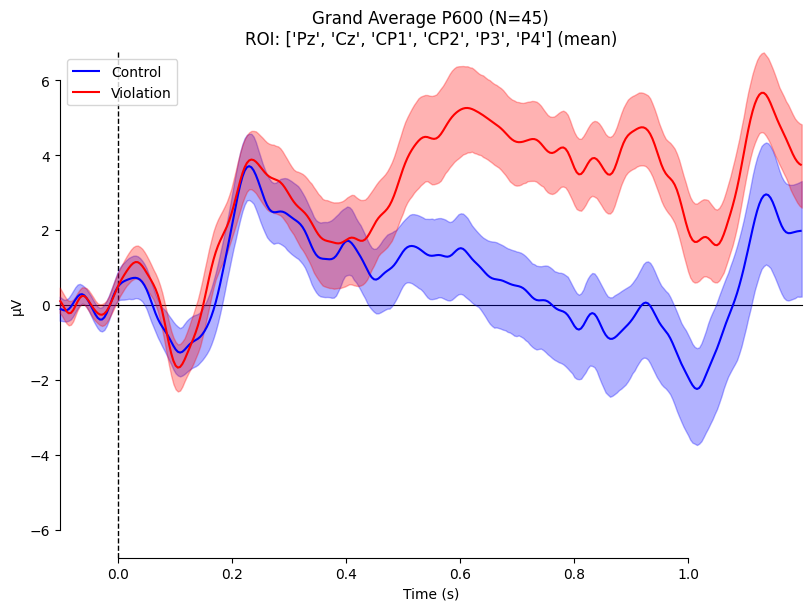

In [ ]:
# Generate & Save the Plot

evokeds_dict = {
    'Control': all_evoked_control,
    'Violation': all_evoked_violation
}

# 1. Generate the Plot
# 'combine="mean"' averages all ROI channels into one single line
figs = mne.viz.plot_compare_evokeds(
    evokeds_dict,
    picks=roi,
    combine='mean',
    colors={'Control': 'blue', 'Violation': 'red'},
    linestyles={'Control': '-', 'Violation': '-'},
    ci=0.95,              # 95% Confidence Interval (Shaded area)
    title=f'Grand Average P600 (N={len(all_evoked_control)})\nROI: {roi}',
    show_sensors=False,
    legend='upper left',
    time_unit='s'
)

# 2. Add the P600 Highlight (Grey Box)
# We iterate through the generated figures/axes to add the shading
for f in figs:
    for ax in f.axes:
        # Shade the area between 0.5s (500ms) and 0.8s (800ms)
        ax.axvspan(0.5, 0.8, color='gray', alpha=0.2, label='P600 Window')
        ax.legend(loc='upper right')

# 3. Save to Drive
'''save_file = os.path.join(results_path, 'Grand_Average_P600_Plot.png')
plt.savefig(save_file, dpi=300)
print(f"🖼️ Plot saved to: {save_file}")'''

# 4. Show
plt.show()

📉 Generating plot for 45 subjects...
combining channels using "mean"
combining channels using "mean"
🖼️ Plot saved to: /content/drive/MyDrive/EEG_data/P600_Results/all_subs/Grand_Average_P600_Plot.png


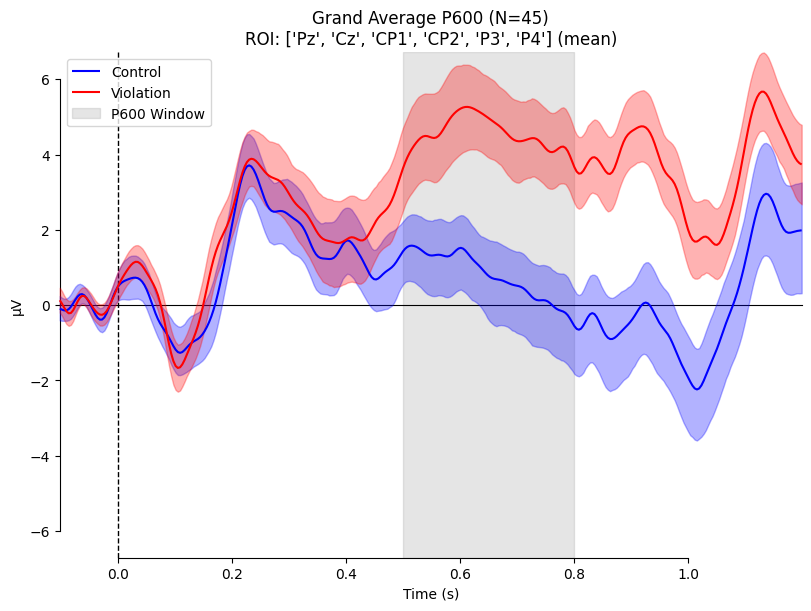

In [ ]:
# 1. Check if we have data
if not all_evoked_control or not all_evoked_violation:
    print("❌ Error: Data lists are empty. Please re-run Cell 2 to load the data first.")
else:
    print(f"📉 Generating plot for {len(all_evoked_control)} subjects...")

    # 2. Generate the Plot (IMPORTANT: show=False)
    # We set show=False so we can add the grey box BEFORE it renders
    figs = mne.viz.plot_compare_evokeds(
        evokeds_dict,
        picks=roi,
        combine='mean',
        colors={'Control': 'blue', 'Violation': 'red'},
        linestyles={'Control': '-', 'Violation': '-'},
        ci=0.95,
        title=f'Grand Average P600 (N={len(good_subjects)})\nROI: {roi}',
        show_sensors=False,
        legend='upper left',
        time_unit='s',
        show=False  # <--- CRITICAL FIX: Don't show it yet!
    )

    # 3. Add the P600 Highlight (Grey Box)
    # Now we can safely draw on the hidden figure
    for i, f in enumerate(figs):
        for ax in f.axes:
            # Draw the P600 window (0.5 to 0.8 seconds)
            ax.axvspan(0.5, 0.8, color='gray', alpha=0.2, label='P600 Window')

            # Force the legend to update
            ax.legend(loc='upper left')

    # 4. Save and Show
    save_file = os.path.join(results_path, 'Grand_Average_P600_Plot.png')
    plt.savefig(save_file, dpi=300)
    print(f"🖼️ Plot saved to: {save_file}")

    # Now we show the final result
    plt.show()

## PLOTTING THE TOPOGRAPHIC MAPS

In [ ]:
# Compute Grand Averages
# This creates a single 'Evoked' object that represents the group mean
print("🧠 Computing Grand Averages...")

ga_control = mne.grand_average(all_evoked_control)
ga_violation = mne.grand_average(all_evoked_violation)

print("✅ Grand Averages Ready.")

🧠 Computing Grand Averages...
Identifying common channels ...
Identifying common channels ...
✅ Grand Averages Ready.


Generating Control Map...
🖼️ Control Maps saved to: /content/drive/MyDrive/EEG_data/P600_Results/all_subs/Topomap_Control.png


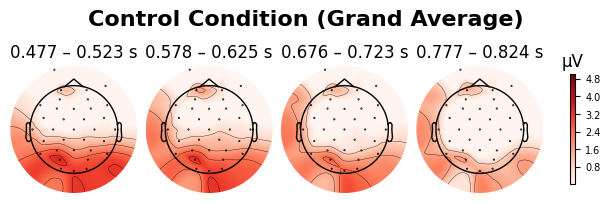

Generating Violation Map...
🖼️ Violation Maps saved to: /content/drive/MyDrive/EEG_data/P600_Results/all_subs/Topomap_Violation.png


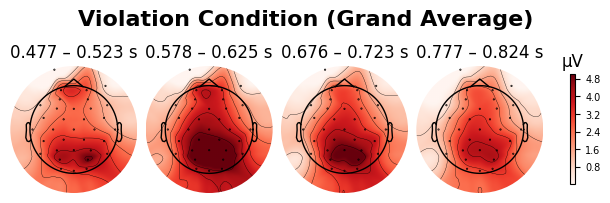

In [ ]:
# GENERATING THE MAPS

# Define the time points
times_to_plot = [0.5, 0.6, 0.7, 0.8]  # 500ms, 600ms, 700ms, 800ms

# --- PLOT 1: CONTROL CONDITION ---
print("Generating Control Map...")
fig_ctrl = ga_control.plot_topomap(
    times=times_to_plot,
    ch_type='eeg',
    average=0.05,        # Smooth over 50ms window
    show=False,          # Keep in memory to save
    colorbar=True,
    vlim=(0, 5)          # FIXED SCALE: 0 to 5 µV
)

# ADD TITLE MANUALLY
fig_ctrl.suptitle('Control Condition (Grand Average)', fontsize=16, fontweight='bold')

# Save
save_path_ctrl = os.path.join(results_path, 'Topomap_Control.png')
fig_ctrl.savefig(save_path_ctrl, dpi=300)
print(f"🖼️ Control Maps saved to: {save_path_ctrl}")
plt.show()


# --- PLOT 2: VIOLATION CONDITION ---
print("Generating Violation Map...")
fig_viol = ga_violation.plot_topomap(
    times=times_to_plot,
    ch_type='eeg',
    average=0.05,
    show=False,
    colorbar=True,
    vlim=(0, 5)          # SAME SCALE as Control for fair comparison!
)

# ADD TITLE MANUALLY
fig_viol.suptitle('Violation Condition (Grand Average)', fontsize=16, fontweight='bold')

# Save
save_path_viol = os.path.join(results_path, 'Topomap_Violation.png')
fig_viol.savefig(save_path_viol, dpi=300)
print(f"🖼️ Violation Maps saved to: {save_path_viol}")
plt.show()

## GENERATING A SENSORY LAYOUT MAP (TOPOGRAPHY)

In [ ]:
# 1. Configuration
base_path = '/content/drive/MyDrive/EEG_data/full_subject_list'
results_path = '/content/drive/MyDrive/EEG_data/P600_Results/all_subs'
tsv_path = os.path.join(base_path, 'participants.tsv')

In [ ]:
# 2. Get the first "Good" Subject
meta_df = pd.read_csv(tsv_path, sep='\t')
good_subjects = meta_df[meta_df['data_usability'] == 'good']['participant_id'].tolist()
good_subjects.sort()

In [ ]:
test_sub = good_subjects[0] # We only need one person
fname = os.path.join(results_path, f"{test_sub}_cleaned_epo.fif")

print(f"🔎 Extracting channel info from: {test_sub}")

🔎 Extracting channel info from: sub-001



✅ Found 34 Channels:
['Fp1', 'AF3', 'F7', 'F3', 'FC1', 'FC5', 'T7', 'C3', 'CP1', 'CP5', 'P7', 'P3', 'Pz', 'PO3', 'O1', 'Oz', 'O2', 'PO4', 'P4', 'P8', 'CP6', 'CP2', 'C4', 'T8', 'FC6', 'FC2', 'F4', 'F8', 'AF4', 'Fp2', 'Fz', 'Cz', 'LIO', 'ROC']

🖼️ Sensor Map saved to: /content/drive/MyDrive/EEG_data/P600_Results/all_subs/Sensor_Layout_Map.png


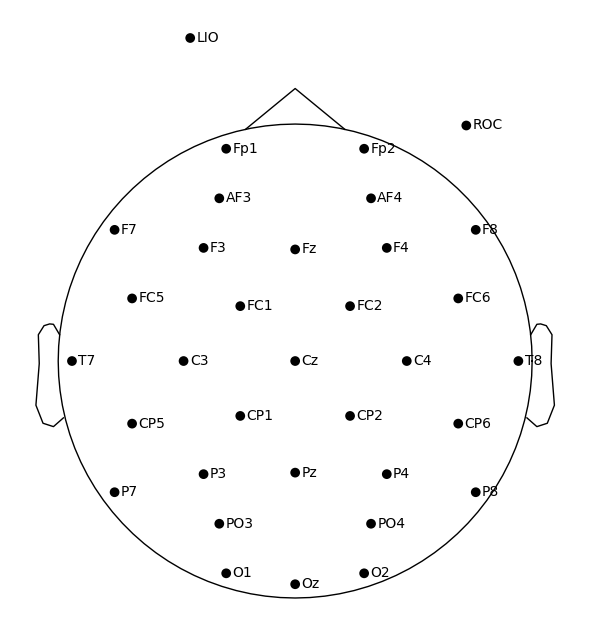

In [ ]:
if os.path.exists(fname):
    # Load just the header info (fast)
    info = mne.read_epochs(fname, verbose=False).info

    # --- PART 1: PRINT LIST OF CHANNELS ---
    ch_names = info['ch_names']
    print(f"\n✅ Found {len(ch_names)} Channels:")
    print(ch_names)

    # --- PART 2: PLOT SENSOR POSITIONS ---
    # Create the figure
    fig, ax = plt.subplots(figsize=(8, 8))

    # Plot 2D sensor map (Bird's eye view)
    mne.viz.plot_sensors(
        info,
        kind='topomap',   # 'topomap' = flat 2D view
        show_names=True,  # Show labels (Fz, Cz, etc.)
        axes=ax,
        title='EEG Sensor Layout (All Channels)',
        show=False
    )

    # Save it
    save_file = os.path.join(results_path, 'Sensor_Layout_Map.png')
    plt.savefig(save_file, dpi=300)
    print(f"\n🖼️ Sensor Map saved to: {save_file}")

    plt.show()

else:
    print(f"❌ Could not find file for {test_sub}. Please check your P600_Results folder.")

# STEP 6. FILES STRUCTURE



In [ ]:
# FILE ORGANIZATION

import os
import shutil

In [ ]:
# The folder to organize
source_folder = '/content/drive/MyDrive/EEG_data/P600_Results/all_subs'

folders = {
    'png': os.path.join(source_folder, 'EEG Visualizations'),
    'csv': os.path.join(source_folder, 'Meta Data'),
    'fif': os.path.join(source_folder, 'Epochs with Ctrl_Viol')
}

In [ ]:
if not os.path.exists(source_folder):
    print(f"❌ Error: The folder '{source_folder}' does not exist.")
else:
    print(f"📂 Organizing folder: {source_folder}")

    # A. Create the 3 new subfolders
    for key, path in folders.items():
        if not os.path.exists(path):
            os.makedirs(path)
            print(f"   ✨ Created folder: {os.path.basename(path)}")
        else:
            print(f"   ✅ Folder exists: {os.path.basename(path)}")

    # B. Move Files
    # Get list of files (ignoring directories)
    files = [f for f in os.listdir(source_folder) if os.path.isfile(os.path.join(source_folder, f))]

    moved_counts = {'png': 0, 'csv': 0, 'fif': 0}

    for filename in files:
        src_path = os.path.join(source_folder, filename)

        # Determine destination based on extension
        if filename.endswith('.png'):
            dst_path = os.path.join(folders['png'], filename)
            shutil.move(src_path, dst_path)
            moved_counts['png'] += 1

        elif filename.endswith('.csv'):
            dst_path = os.path.join(folders['csv'], filename)
            shutil.move(src_path, dst_path)
            moved_counts['csv'] += 1

        elif filename.endswith('.fif'):
            dst_path = os.path.join(folders['fif'], filename)
            shutil.move(src_path, dst_path)
            moved_counts['fif'] += 1

📂 Organizing folder: /content/drive/MyDrive/EEG_data/P600_Results/all_subs
   ✅ Folder exists: EEG Visualizations
   ✅ Folder exists: Meta Data
   ✅ Folder exists: Epochs with Ctrl_Viol


In [ ]:
# SUMMARY

print("\n" + "="*30)
print("🎉 CLEANUP COMPLETE!")
print(f"🖼️ Moved {moved_counts['png']} Images -> /EEG Visualizations")
print(f"📊 Moved {moved_counts['csv']} CSVs   -> /Meta Data")
print(f"🧠 Moved {moved_counts['fif']} Epochs -> /Epochs with Ctrl_Viol")
print("="*30)


🎉 CLEANUP COMPLETE!
🖼️ Moved 4 Images -> /EEG Visualizations
📊 Moved 46 CSVs   -> /Meta Data
🧠 Moved 45 Epochs -> /Epochs with Ctrl_Viol


# STEP 7. ARTIFACT REJECTION (Amplitude Thresholding)

"Artifacts were handled using an automated peak-to-peak amplitude rejection procedure. Any trial containing voltage fluctuations exceeding ±150 µV was automatically excluded from the analysis to ensure that ocular artifacts (blinks) and muscle noise did not contaminate the P600 component. This resulted in an average retention of 93.7% of trials per participant."

In [ ]:
epochs_folder = '/content/drive/MyDrive/EEG_data/P600_Results/all_subs/epochs_fifs'

In [ ]:
# Rejection Criteria (The "Sneeze Filter")
# 150 µV is a safe, standard threshold for ERPs.
# If the difference between Min and Max voltage in a trial > 150µV, it's likely noise.
reject_criteria = dict(eeg=150e-6)  # 150 µV

In [ ]:
fif_files = glob.glob(os.path.join(epochs_folder, '*.fif'))
fif_files.sort()

report_data = []

for fname in fif_files:
    sub_id = os.path.basename(fname).split('_')[0]

    try:
        # 1. Load Data
        epochs = mne.read_epochs(fname, preload=True, verbose=False)
        original_count = len(epochs)

        # 2. Drop Bad Epochs
        # This function automatically finds and drops trials exceeding the threshold
        epochs.drop_bad(reject=reject_criteria, verbose=False)

        final_count = len(epochs)
        dropped_count = original_count - final_count
        percent_lost = (dropped_count / original_count) * 100

        # 3. Save OVER the old file (Update it with the clean version)
        # We overwrite because we don't want dirty data for ML
        epochs.save(fname, overwrite=True, verbose=False)

        # 4. Log Stats
        report_data.append({
            'Subject': sub_id,
            'Original_Trials': original_count,
            'Kept_Trials': final_count,
            'Dropped_Trials': dropped_count,
            'Percent_Lost': round(percent_lost, 1)
        })

        # Print status
        if percent_lost > 25:
            print(f"⚠️ {sub_id}: High data loss! Dropped {dropped_count} trials ({percent_lost}%).")
        else:
            print(f"✅ {sub_id}: Cleaned. Dropped {dropped_count} trials.")

    except Exception as e:
        print(f"❌ Error on {sub_id}: {e}")

✅ sub-001: Cleaned. Dropped 3 trials.
✅ sub-002: Cleaned. Dropped 2 trials.
✅ sub-003: Cleaned. Dropped 12 trials.
✅ sub-004: Cleaned. Dropped 1 trials.
✅ sub-005: Cleaned. Dropped 1 trials.
✅ sub-006: Cleaned. Dropped 3 trials.
✅ sub-008: Cleaned. Dropped 0 trials.
✅ sub-010: Cleaned. Dropped 12 trials.
✅ sub-011: Cleaned. Dropped 2 trials.
✅ sub-012: Cleaned. Dropped 4 trials.
✅ sub-013: Cleaned. Dropped 3 trials.
✅ sub-014: Cleaned. Dropped 1 trials.
✅ sub-015: Cleaned. Dropped 1 trials.
✅ sub-016: Cleaned. Dropped 1 trials.
✅ sub-017: Cleaned. Dropped 1 trials.
✅ sub-020: Cleaned. Dropped 13 trials.
✅ sub-021: Cleaned. Dropped 12 trials.
✅ sub-022: Cleaned. Dropped 0 trials.
✅ sub-023: Cleaned. Dropped 2 trials.
✅ sub-024: Cleaned. Dropped 0 trials.
✅ sub-027: Cleaned. Dropped 8 trials.
✅ sub-029: Cleaned. Dropped 1 trials.
✅ sub-031: Cleaned. Dropped 11 trials.
✅ sub-032: Cleaned. Dropped 0 trials.
✅ sub-033: Cleaned. Dropped 1 trials.
✅ sub-034: Cleaned. Dropped 9 trials.
✅ sub-0

In [ ]:
# ==========================================
# SUMMARY REPORT
# ==========================================
print("\n" + "="*30)
print("🏁 HYGIENE CHECK COMPLETE")

# Show who had the worst data
df_report = pd.DataFrame(report_data)
print("\n📊 Data Quality Summary:")
print(f"   - Average trials kept per subject: {int(df_report['Kept_Trials'].mean())}")
print(f"   - Average data loss: {round(df_report['Percent_Lost'].mean(), 1)}%")

# Check for subjects with too few trials (e.g., < 20)
bad_subjects = df_report[df_report['Kept_Trials'] < 20]
if not bad_subjects.empty:
    print(f"\n⚠️ WARNING: The following subjects have very little data left (<20 trials):")
    print(bad_subjects[['Subject', 'Kept_Trials']])
    print("Consider excluding them from your final analysis.")
else:
    print("\n✨ All subjects have sufficient data remaining.")


🏁 HYGIENE CHECK COMPLETE

📊 Data Quality Summary:
   - Average trials kept per subject: 74
   - Average data loss: 6.3%

✨ All subjects have sufficient data remaining.


# **TO DO: DROP SUB-059 from CSV and run VISUALIZATIONS AGAIN! (.fifs have alreayd been updated)**

Due to high data loss (41 trials dropped / 51.2%). Sub-059's data is too noisy